In [322]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings
from tqdm import tqdm_notebook

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4


|Task: To predict whether the user likes the mobile phone or not.    
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

Missing values: 'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447) 'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467), 'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473), 'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456), 'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

Very low variance: 'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'

Multivalued: 'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

Not important: 'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

Doubtful: 'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing), 'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'

To check: 'Display Type','Expandable Memory','FM Radio'

High Correlation with other features 'SIM Slot(s)' high correlation with SIM1 'Weight' has high high correlation with capacity , screen-to-body ratio 'Height' - screen size is also there

Given a mobile, we can't directly get these features 'Rating Count', 'Review Count'

Keeping: 'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',

In [323]:
!cd dataset

In [324]:
pwd 

'C:\\Users\\suraj\\Desktop\\mtech_sem2\\GUVI DeepLearning\\Mobile_Like_Dislike_MPNeuron'

In [325]:
ls dataset\

 Volume in drive C has no label.
 Volume Serial Number is 1A29-EE7C

 Directory of C:\Users\suraj\Desktop\mtech_sem2\GUVI DeepLearning\Mobile_Like_Dislike_MPNeuron\dataset

11-04-2020  17:27    <DIR>          .
11-04-2020  17:27    <DIR>          ..
11-04-2020  17:27           377,773 test.csv
11-04-2020  17:27         1,120,925 train.csv
               2 File(s)      1,498,698 bytes
               2 Dir(s)  111,755,116,544 bytes free


In [326]:
train = pd.read_csv('./dataset/train.csv')
test= pd.read_csv('./dataset/test.csv')

In [327]:
print(train.shape, test.shape)

(355, 99) (119, 98)


In [328]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [329]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing feature

Before cleaning the data

In [330]:
print(train.columns)

Index(['PhoneId', 'Also Known As', 'Applications', 'Architecture', 'Aspect Ratio', 'Audio Features', 'Audio Jack', 'Autofocus', 'Bezel-less display', 'Bluetooth', 'Brand', 'Browser', 'Build Material', 'Camera Features', 'Capacity', 'Chipset', 'Co-Processor', 'Colours', 'Custom UI', 'Display Colour', 'Display Type', 'Email', 'Expandable Memory', 'FM Radio', 'Fingerprint Sensor', 'Fingerprint Sensor Position', 'Flash', 'GPS', 'Games', 'Graphics', 'HDMI', 'Heart Rate Monitor', 'Height', 'IRIS Scanner', 'Image Resolution', 'Internal Memory', 'Java', 'Launch Date', 'Loudspeaker', 'Mobile High-Definition Link(MHL)', 'Model', 'Music', 'NFC', 'Network', 'Network Support', 'Operating System', 'Optical Image Stabilisation', 'Other Facilities', 'Other Sensors', 'Phone Book', 'Physical Aperture', 'Pixel Density', 'Processor', 'Quick Charging', 'RAM', 'Rating Count', 'Resolution', 'Review Count', 'Ring Tone', 'Ruggedness', 'SAR Value', 'SIM 1', 'SIM 2', 'SIM 3', 'SIM Size', 'SIM Slot(s)', 'SMS',
  

In [331]:
train = data_clean(train)
test = data_clean(test)

After cleaning Data

In [332]:
print(train.columns)

Index(['Pixel Density', 'Type', 'Shooting Modes', 'Resolution', 'FM Radio', 'Image Resolution', 'Operating System', 'Rating', 'Chipset', 'Bezel-less display', 'RAM', 'Graphics', 'PhoneId', 'Camera Features', 'SIM 2', 'Processor', 'Screen Size', 'User Available Storage', 'SIM 1', 'Screen to Body Ratio (calculated)', 'Height', 'Fingerprint Sensor', 'Width', 'Rating Count', 'Model', 'Review Count', 'Touch Screen', 'Autofocus', 'Screen Resolution', 'SIM Slot(s)', 'Other Sensors', 'Brand', 'Flash', 'NFC', 'Display Type', 'Expandable Memory', 'Internal Memory', 'Thickness', 'Aspect Ratio', 'Colours', 'Display Colour', 'Weight', 'SIM Size', 'User Replaceable', 'Capacity', 'Browser', 'USB Connectivity'], dtype='object')


In [333]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [334]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


In [335]:
train.head()

,Pixel Density,Type,Shooting Modes,Resolution,FM Radio,Image Resolution,Operating System,Rating,Chipset,Bezel-less display,RAM,Graphics,PhoneId,Camera Features,SIM 2,Processor,Screen Size,User Available Storage,SIM 1,Screen to Body Ratio (calculated),Height,Fingerprint Sensor,Width,Rating Count,Model,Review Count,Touch Screen,Autofocus,Screen Resolution,SIM Slot(s),Other Sensors,Brand,Flash,NFC,Display Type,Expandable Memory,Internal Memory,Thickness,Aspect Ratio,Colours,Display Colour,Weight,SIM Size,User Replaceable,Capacity,Browser,USB Connectivity
0,403 ppi Best in Class ▾Pixel Density compared ...,Li-Polymer,"Continuos Shooting, High Dynamic Range mode (H...",20 MP + 2 MP Dual Front Cameras Best in Class ...,NaN,4000 x 3000 Pixels,Android v8.1 (Oreo),4.5,Qualcomm Snapdragon 636,yes,4 GB Excellent ▾RAM compared to11 - 17 K Phone...,Adreno 509,0,"Digital Zoom, Auto Flash, Face detection, Touc...",4G Bands: TD-LTE 2300(band 40) / 2500(band 41)...,"Octa core (1.8 GHz, Quad core, Kryo 260 + 1.6 ...",6.26 inches (15.9 cm),Up to 52.3 GB,4G Bands:TD-LTE 2300(band 40) / 2500(band 41) ...,80.68 %,157.9 mm Compare Size,yes,76.4 mm,172274,Redmi Note 6 Pro,17138,"Capacitive Touchscreen, Multi-touch",Phase Detection autofocus,1080 x 2280 pixels,"Dual SIM, GSM+GSM, Dual VoLTE","Light sensor, Proximity sensor, Accelerometer,...",Xiaomi,Dual-color LED Flash,NaN,IPS LCD,Up to 256 GB,64 GB Best in Class ▾Internal Memory compared ...,8.2 mm Very Good ▾Thickness compared to11 - 17...,19:9,"Black, Blue, Red, Rose Gold",NaN,182 grams Below Average ▾Weight compared to11 ...,"SIM1: Nano, SIM2: Nano (Hybrid)",No,4000 mAh,NaN,"Mass storage device, USB charging, microUSB 2.0"
1,271 ppi Good ▾Pixel Density compared to8 - 12 ...,Li-ion,"Continuos Shooting, High Dynamic Range mode (HDR)",8 MP Front Camera Very Good ▾Front Camera comp...,NaN,4128 x 3096 Pixels,Android v8.1 (Oreo),4.5,Qualcomm Snapdragon 450,yes,3 GB Excellent ▾RAM compared to8 - 12 K Phones...,Adreno 506,1,"2 x Digital Zoom, Auto Flash, Face detection, ...",4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,"Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...",6.2 inches (15.75 cm),Up to 23.2 GB,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,80.85 %,156.2 mm Compare Size,yes,75.6 mm,339447,2,38252,"Capacitive Touchscreen, Multi-touch",Phase Detection autofocus,720 x 1520 pixels,"Dual SIM, GSM+GSM, Dual VoLTE","Light sensor, Proximity sensor, Accelerometer,...",Realme,LED Flash,No,IPS LCD,Up to 256 GB,32 GB Excellent ▾Internal Memory compared to8 ...,8.2 mm Very Good ▾Thickness compared to8 - 12 ...,19:9,"Diamond Black, Diamond Blue, Diamond Red",NaN,168 grams Average ▾Weight compared to8 - 12 K ...,"SIM1: Nano, SIM2: Nano",No,4230 mAh,NaN,"Mass storage device, USB charging, microUSB 2.0"
2,409 ppi Best in Class ▾Pixel Density compared ...,Li-ion,"Continuos Shooting, High Dynamic Range mode (HDR)",25 MP Front Camera Best in Class ▾Front Camera...,yes,4128 x 3096 Pixels,Android v8.1 (Oreo),4.4,MediaTek Helio P70,yes,3 GB Excellent ▾RAM compared to10 - 14 K Phone...,Mali-G72 MP3,2,"2 x Digital Zoom, Auto Flash, Face detection, ...",4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,"Octa core (2.1 GHz, Quad core, Cortex A73 + 2 ...",6.3 inches (16 cm),NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,83.68 %,157 mm Compare Size,yes,74 mm,1149,U1,1151,"Capacitive Touchscreen, Multi-touch",yes,1080 x 2340 pixels,"Dual SIM, GSM+GSM, Dual VoLTE","Light sensor, Proximity sensor, Accelerometer",Realme,LED Flash,NaN,IPS LCD,Up to 256 GB,32 GB Excellent ▾Internal Memory compared to10...,8 mm Very Good ▾Thickness compared to10 - 14 K...,19.5:9,"Brave Blue, Fiery Gold, Ambitious Black",NaN,168 grams Average ▾Weight compared to10 - 14 K...,"SIM1: Nano, SIM2: Nano",No,3500 mAh,NaN,"Mass storage device, USB charging, microUSB 2.0"
3,411 ppi Best in Class ▾Pixel Density compared ...,Li-ion,"Continuos Shooting, High Dynamic Range mode (HDR)",24 MP Front Camera Best in Class ▾Front Camera...,yes,5288 x

# Filling Missing Values

In [336]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

In [337]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_Internal_Memory)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isnull() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isnull() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isnull() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isnull() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isnull() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isnull() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isnull() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isnull() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isnull() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isnull() == True] = "Other"
    
    return data

In [338]:
train1 = train.copy()
train = data_clean_2(train)

test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


In [339]:
train.columns

Index(['Pixel Density', 'Type', 'Shooting Modes', 'Resolution', 'FM Radio', 'Image Resolution', 'Operating System', 'Rating', 'Chipset', 'Bezel-less display', 'RAM', 'Graphics', 'PhoneId', 'Camera Features', 'SIM 2', 'Processor', 'Screen Size', 'User Available Storage', 'SIM 1', 'Screen to Body Ratio (calculated)', 'Height', 'Fingerprint Sensor', 'Width', 'Rating Count', 'Model', 'Review Count', 'Touch Screen', 'Autofocus', 'Screen Resolution', 'SIM Slot(s)', 'Other Sensors', 'Brand', 'Flash', 'NFC', 'Display Type', 'Expandable Memory', 'Internal Memory', 'Thickness', 'Aspect Ratio', 'Colours', 'Display Colour', 'Weight', 'SIM Size', 'User Replaceable', 'Capacity', 'Browser', 'USB Connectivity', 'Num_cores', 'Processor_frequency', 'os_name', 'Sim1'], dtype='object')

In [340]:
train.head()

,Pixel Density,Type,Shooting Modes,Resolution,FM Radio,Image Resolution,Operating System,Rating,Chipset,Bezel-less display,RAM,Graphics,PhoneId,Camera Features,SIM 2,Processor,Screen Size,User Available Storage,SIM 1,Screen to Body Ratio (calculated),Height,Fingerprint Sensor,Width,Rating Count,Model,Review Count,Touch Screen,Autofocus,Screen Resolution,SIM Slot(s),Other Sensors,Brand,Flash,NFC,Display Type,Expandable Memory,Internal Memory,Thickness,Aspect Ratio,Colours,Display Colour,Weight,SIM Size,User Replaceable,Capacity,Browser,USB Connectivity,Num_cores,Processor_frequency,os_name,Sim1
0,403,Li-Polymer,"Continuos Shooting, High Dynamic Range mode (H...",20,NaN,4000 x 3000 Pixels,Android v8.1 (Oreo),4.5,Qualcomm Snapdragon 636,yes,4,Adreno 509,0,"Digital Zoom, Auto Flash, Face detection, Touc...",4G,"Octa core (1.8 GHz, Quad core, Kryo 260 + 1.6 ...",6.26,Up to 52.3 GB,4G Bands:TD-LTE 2300(band 40) / 2500(band 41) ...,80.68,157.9,yes,76.4,172274,Redmi Note 6 Pro,17138,"Capacitive Touchscreen, Multi-touch",Phase Detection autofocus,1080 x 2280 pixels,"Dual SIM, GSM+GSM, Dual VoLTE","Light sensor, Proximity sensor, Accelerometer,...",Xiaomi,Dual-color LED Flash,NaN,IPS LCD,Up to 256 GB,64,8.2,19:9,"Black, Blue, Red, Rose Gold",NaN,182,"SIM1: Nano, SIM2: Nano (Hybrid)",No,4000,NaN,"Mass storage device, USB charging, microUSB 2.0",Octa,1.8,Android,4G
1,271,Li-ion,"Continuos Shooting, High Dynamic Range mode (HDR)",8,NaN,4128 x 3096 Pixels,Android v8.1 (Oreo),4.5,Qualcomm Snapdragon 450,yes,3,Adreno 506,1,"2 x Digital Zoom, Auto Flash, Face detection, ...",4G,"Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...",6.20,Up to 23.2 GB,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,80.85,156.2,yes,75.6,339447,2,38252,"Capacitive Touchscreen, Multi-touch",Phase Detection autofocus,720 x 1520 pixels,"Dual SIM, GSM+GSM, Dual VoLTE","Light sensor, Proximity sensor, Accelerometer,...",Realme,LED Flash,No,IPS LCD,Up to 256 GB,32,8.2,19:9,"Diamond Black, Diamond Blue, Diamond Red",NaN,168,"SIM1: Nano, SIM2: Nano",No,4230,NaN,"Mass storage device, USB charging, microUSB 2.0",Octa,1.8,Android,4G
2,409,Li-ion,"Continuos Shooting, High Dynamic Range mode (HDR)",25,yes,4128 x 3096 Pixels,Android v8.1 (Oreo),4.4,MediaTek Helio P70,yes,3,Mali-G72 MP3,2,"2 x Digital Zoom, Auto Flash, Face detection, ...",4G,"Octa core (2.1 GHz, Quad core, Cortex A73 + 2 ...",6.30,NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,83.68,157.0,yes,74.0,1149,U1,1151,"Capacitive Touchscreen, Multi-touch",yes,1080 x 2340 pixels,"Dual SIM, GSM+GSM, Dual VoLTE","Light sensor, Proximity sensor, Accelerometer",Realme,LED Flash,NaN,IPS LCD,Up to 256 GB,32,8.0,19.5:9,"Brave Blue, Fiery Gold, Ambitious Black",NaN,168,"SIM1: Nano, SIM2: Nano",No,3500,NaN,"Mass storage device, USB charging, microUSB 2.0",Octa,2.1,Android,4G
3,411,Li-ion,"Continuos Shooting, High Dynamic Range mode (HDR)",24,yes,5288 x 3968 Pixels,Android v8.0 (Oreo),4.3,Samsung Exynos 7 Octa 7885,yes,4,Mali-G71 MP2,4,"Digital Zoom, Auto Flash, Face detection, Touc...",4G,"Octa core (2.2 GHz, Dual core, Cortex A73 + 1....",6.00,Up to 49.2 GB,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,74.78,159.8,yes,76.8,6026,Galaxy A7 2018,779,"Capacitive Touchscreen, Multi-touch",No,1080 x 2220 pixels,"Dual SIM, GSM+GSM","Light sensor, Proximity sensor, Accelerometer,...",Samsung,LED Flash,No,Super AMOLED,Up to 512 GB,64,7.5,18.5:9,"Black, Blue, Gold",NaN,169,"SIM1: Nano, SIM2: Nano",No,3300,NaN,"Mass storage device, USB charging, microUSB 2.0",Octa,2.2,Android,4G
4,396,Li-Polymer,"Continuos Shooting, High Dynamic Range mode (HDR)",16,yes,5160 x 3872 Pixels,Android v8.1 (Oreo),4.4,HiSilicon Kirin 710,yes,4,Mali-G51 MP4,5,"Digital Zoom, Auto Flash, Face detection, Touc...",4G,"Octa core (2.2 GHz, Quad core, Cortex A73 + 1....",6.50,Up to 53.3 GB,4G Bands:TD-LTE 2300(band 40) FD-LTE 1800(band...,84.23,160.4,yes,76.6,5175,8X,5177,"Capacitive Touchscreen, Multi-touch",Phase Detection autofocus,1080 x 2340 pixels,"Dua

Not very important feature

In [341]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [342]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [343]:
train[train['PhoneId']==56]

,Pixel Density,RAM,Sim1,Height,PhoneId,Internal Memory,Capacity,Num_cores,Weight,Processor_frequency,SIM 2,Resolution,os_name,SIM Slot(s),Screen Size,Brand,Screen to Body Ratio (calculated),Rating
40,401,4,4G,154.5,56,64,4000,Deca,180,2.3,4G,13,Android,"Dual SIM, GSM+GSM",5.5,Lenovo,70.95,3.8


In [344]:
train.columns

Index(['Pixel Density', 'RAM', 'Sim1', 'Height', 'PhoneId', 'Internal Memory', 'Capacity', 'Num_cores', 'Weight', 'Processor_frequency', 'SIM 2', 'Resolution', 'os_name', 'SIM Slot(s)', 'Screen Size', 'Brand', 'Screen to Body Ratio (calculated)', 'Rating'], dtype='object')

In [345]:
test.columns

Index(['Pixel Density', 'RAM', 'Sim1', 'Height', 'PhoneId', 'Internal Memory', 'Capacity', 'Num_cores', 'Weight', 'Processor_frequency', 'SIM 2', 'Resolution', 'os_name', 'SIM Slot(s)', 'Screen Size', 'Brand', 'Screen to Body Ratio (calculated)'], dtype='object')

In [346]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Pixel Density', 'RAM', 'Sim1', 'Height', 'Internal Memory', 'Capacity', 'Num_cores', 'Weight', 'Processor_frequency', 'SIM 2', 'Resolution', 'os_name', 'SIM Slot(s)', 'Screen Size', 'Brand', 'Screen to Body Ratio (calculated)'], dtype='object')
(460, 87)
Index(['PhoneId', 'Pixel Density', 'RAM', 'Height', 'Internal Memory', 'Capacity', 'Weight', 'Processor_frequency', 'Resolution', 'Screen Size', 'Screen to Body Ratio (calculated)', 'Sim1_2G', 'Sim1_3G', 'Sim1_4G', 'Num_cores_312', 'Num_cores_Deca', 'Num_cores_Dual', 'Num_cores_Hexa', 'Num_cores_Octa', 'Num_cores_Other', 'Num_cores_Quad', 'Num_cores_Tru-Octa', 'SIM 2_2G', 'SIM 2_3G', 'SIM 2_4G', 'SIM 2_Other', 'os_name_Android', 'os_name_Blackberry', 'os_name_KAI', 'os_name_Nokia', 'os_name_Other', 'os_name_Tizen', 'os_name_iOS', 'SIM Slot(s)_Dual SIM, GSM+CDMA', 'SIM Slot(s)_Dual SIM, GSM+GSM', 'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE', 'SIM Slot(s)_Single SIM, GSM', 'Brand_10.or', 'Brand_Apple', 'Brand_

In [347]:
#pd.set_option('display.height',1000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',100)
pd.set_option('display.width',1000)
train_new.head()

,PhoneId,Pixel Density,RAM,Height,Internal Memory,Capacity,Weight,Processor_frequency,Resolution,Screen Size,Screen to Body Ratio (calculated),Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi
0,0,403,4,157.9,64,4000,182,1.8,20,6.26,80.68,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,271,3,156.2,32,4230,168,1.8,8,6.20,80.85,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,409,3,157.0,32,3500,168,2.1,25,6.30,83.68,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,411,4,159.8,64,3300,169,2.2,24,6.00,74.78,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,396,4,160.4,64,3750,175,2.2,16,6.50,84.23,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [348]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [349]:
train_new.head()

,PhoneId,Pixel Density,RAM,Height,Internal Memory,Capacity,Weight,Processor_frequency,Resolution,Screen Size,Screen to Body Ratio (calculated),Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Rating
0,0,403,4,157.9,64,4000,182,1.8,20,6.26,80.68,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4.5
1,1,271,3,156.2,32,4230,168,1.8,8,6.20,80.85,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.5
2,2,409,3,157.0,32,3500,168,2.1,25,6.30,83.68,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.4
3,4,411,4,159.8,64,3300,169,2.2,24,6.00,74.78,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.3
4,5,396,4,160.4,64,3750,175,2.2,16,6.50,84.23,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.4


In [350]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


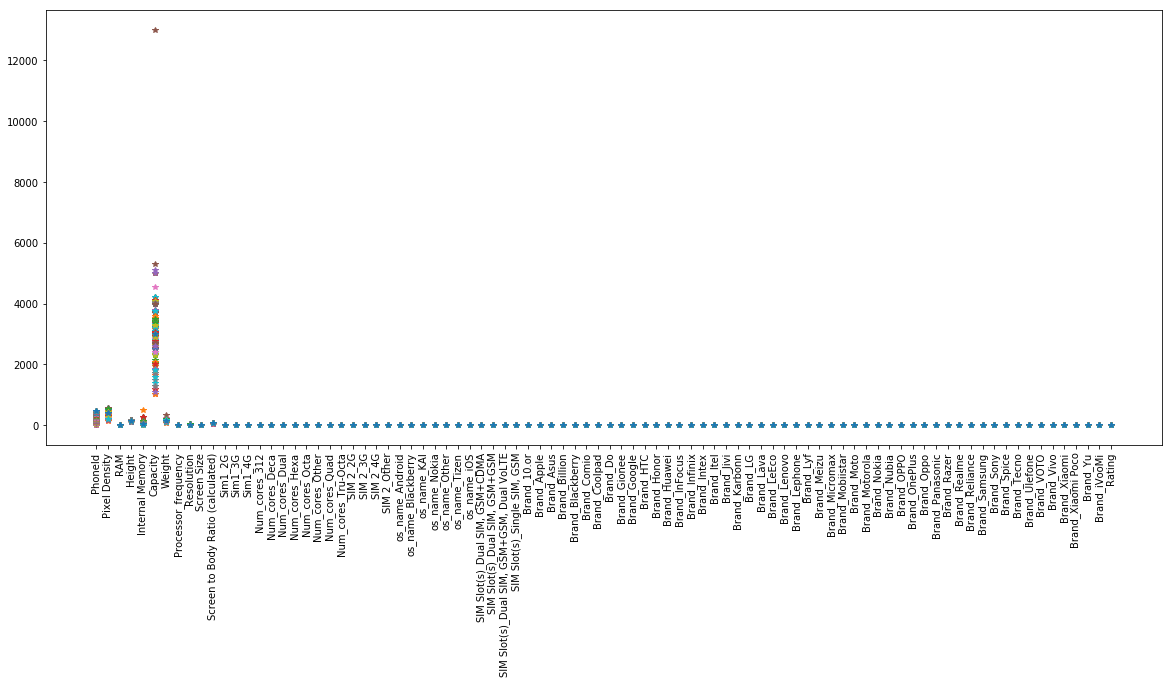

In [351]:
plt.figure(figsize=(20, 8))
plt.plot(train_new.T,'*')
plt.xticks(rotation = 'vertical')
plt.show()

In [352]:
train_new['Liked']  = train_new['Rating'].map(lambda x: 0 if x <= 3.9 else 1) 

In [353]:
train_new.groupby('Liked').mean()

,PhoneId,Pixel Density,RAM,Height,Internal Memory,Capacity,Weight,Processor_frequency,Resolution,Screen Size,Screen to Body Ratio (calculated),Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Rating
Liked,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,299.485437,327.116505,2.68932,146.980823,30.330097,2984.805825,158.84466,1.568447,7.601942,5.163689,69.088544,0.009709,0.048544,0.941748,0.000000,0.019417,0.038835,0.009709,0.436893,0.009709,0.485437,0.000000,0.330097,0.029126,0.582524,0.058252,0.932039,0.019417,0.019417,0.000000,0.019417,0.009709,0.000000,0.000000,0.902913,0.038835,0.058252,0.019417,0.000000,0.009709,0.0,0.038835,0.000000,0.019417,0.0,0.038835,0.000000,0.048544,0.019417,0.00000,0.029126,0.009709,0.038835,0.009709,0.009709,0.019417,0.058252,0.019417,0.000000,0.058252,0.009709,0.009709,0.000000,0.116505,0.029126,0.048544,0.000000,0.077670,0.009709,0.000000,0.000000,0.009709,0.019417,0.009709,0.000000,0.009709,0.058252,0.048544,0.0,0.009709,0.000000,0.009709,0.019417,0.019417,0.000000,0.029126,0.009709,3.620388
1,204.184874,351.609244,3.47479,151.229813,53.310924,3280.676471,162.42437,1.889538,10.453782,5.591555,73.766261,0.025210,0.008403,0.966387,0.004202,0.000000,0.025210,0.046218,0.642857,0.021008,0.256303,0.004202,0.159664,0.016807,0.726891,0.096639,0.894958,0.000000,0.000000,0.004202,0.021008,0.000000,0.079832,0.004202,0.697479,0.201681,0.096639,0.000000,0.079832,0.029412,0.0,0.004202,0.004202,0.000000,0.0,0.025210,0.016807,0.004202,0.063025,0.02521,0.000000,0.008403,0.000000,0.012605,0.000000,0.000000,0.012605,0.016807,0.004202,0.037815,0.000000,0.000000,0.008403,0.012605,0.004202,0.042017,0.008403,0.054622,0.000000,0.058824,0.012605,0.021008,0.008403,0.000000,0.016807,0.000000,0.159664,0.016807,0.0,0.029412,0.004202,0.000000,0.100840,0.079832,0.012605,0.004202,0.000000,4.268067


In [354]:
print(train_new['Liked'].value_counts())

1    238
0    103
Name: Liked, dtype: int64


In [355]:
X_train = train_new.drop('Liked', axis = 1)
X_train = X_train.drop('Rating', axis = 1)
X_train = X_train.drop('PhoneId', axis = 1)

Y_train = train_new['Liked']

In [356]:
X_test = test_new.drop('PhoneId', axis = 1) 
X_test.head()

,Pixel Density,RAM,Height,Internal Memory,Capacity,Weight,Processor_frequency,Resolution,Screen Size,Screen to Body Ratio (calculated),Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi
0,271,2,156.2,16,4230,168,1.8,5,6.20,80.85,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,402,4,156.0,64,5000,205,1.8,12,6.20,81.60,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,409,6,156.7,64,3500,169,2.0,25,6.30,83.84,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,409,4,156.7,64,3500,169,2.0,16,6.30,83.84,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,403,4,158.6,64,4000,181,1.8,20,5.99,77.43,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [357]:
X_train.head()

,Pixel Density,RAM,Height,Internal Memory,Capacity,Weight,Processor_frequency,Resolution,Screen Size,Screen to Body Ratio (calculated),Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi
0,403,4,157.9,64,4000,182,1.8,20,6.26,80.68,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,271,3,156.2,32,4230,168,1.8,8,6.20,80.85,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,409,3,157.0,32,3500,168,2.1,25,6.30,83.68,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,411,4,159.8,64,3300,169,2.2,24,6.00,74.78,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,396,4,160.4,64,3750,175,2.2,16,6.50,84.23,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Standardising input data 

In [358]:
X_train['Pixel Density'] = X_train['Pixel Density'].map(lambda x: (x - X_train['Pixel Density'].min()) / (X_train['Pixel Density'].max() - X_train['Pixel Density'].min()))
X_train['RAM'] = X_train['RAM'].map(lambda x: (x - X_train['RAM'].min()) / (X_train['RAM'].max() - X_train['RAM'].min()))
X_train['Internal Memory'] = X_train['Internal Memory'].map(lambda x: (x - X_train['Internal Memory'].min()) / (X_train['Internal Memory'].max() - X_train['Internal Memory'].min()))
X_train['Weight'] = X_train['Weight'].map(lambda x: (x - X_train['Weight'].min()) / (X_train['Weight'].max() - X_train['Weight'].min()))
X_train['Capacity'] = X_train['Capacity'].map(lambda x: (x - X_train['Capacity'].min())/(X_train['Capacity'].max() - X_train['Capacity'].min())) 


In [359]:
X_train['Processor_frequency'] = X_train['Processor_frequency'].map(lambda x: (x - X_train['Processor_frequency'].min()) / (X_train['Processor_frequency'].max() - X_train['Processor_frequency'].min()))
X_train['Resolution'] = X_train['Resolution'].map(lambda x: (x - X_train['Resolution'].min()) / (X_train['Resolution'].max() - X_train['Resolution'].min()))
X_train['Screen Size'] = X_train['Screen Size'].map(lambda x: (x - X_train['Screen Size'].min()) / (X_train['Screen Size'].max() - X_train['Screen Size'].min()))
X_train['Screen to Body Ratio (calculated)'] = X_train['Screen to Body Ratio (calculated)'].map(lambda x: (x - X_train['Screen to Body Ratio (calculated)'].min()) / (X_train['Screen to Body Ratio (calculated)'].max() - X_train['Screen to Body Ratio (calculated)'].min()))
X_train['Height'] = X_train['Height'].map(lambda x: (x - X_train['Height'].min()) / (X_train['Height'].max() - X_train['Height'].min()))

In [360]:
X_test['Pixel Density'] = X_test['Pixel Density'].map(lambda x: (x - X_test['Pixel Density'].min()) / (X_test['Pixel Density'].max() - X_test['Pixel Density'].min()))
X_test['RAM'] = X_test['RAM'].map(lambda x: (x - X_test['RAM'].min()) / (X_test['RAM'].max() - X_test['RAM'].min()))
X_test['Internal Memory'] = X_test['Internal Memory'].map(lambda x: (x - X_test['Internal Memory'].min()) / (X_test['Internal Memory'].max() - X_test['Internal Memory'].min()))
X_test['Weight'] = X_test['Weight'].map(lambda x: (x - X_test['Weight'].min()) / (X_test['Weight'].max() - X_test['Weight'].min()))
X_test['Capacity'] = X_test['Capacity'].map(lambda x: (x - X_test['Capacity'].min())/(X_test['Capacity'].max() - X_test['Capacity'].min())) 


In [361]:
X_test['Processor_frequency'] = X_test['Processor_frequency'].map(lambda x: (x - X_test['Processor_frequency'].min()) / (X_test['Processor_frequency'].max() - X_test['Processor_frequency'].min()))
X_test['Resolution'] = X_test['Resolution'].map(lambda x: (x - X_test['Resolution'].min()) / (X_test['Resolution'].max() - X_test['Resolution'].min()))
X_test['Screen Size'] = X_test['Screen Size'].map(lambda x: (x - X_test['Screen Size'].min()) / (X_test['Screen Size'].max() - X_test['Screen Size'].min()))
X_test['Screen to Body Ratio (calculated)'] = X_test['Screen to Body Ratio (calculated)'].map(lambda x: (x - X_test['Screen to Body Ratio (calculated)'].min()) / (X_test['Screen to Body Ratio (calculated)'].max() - X_test['Screen to Body Ratio (calculated)'].min()))
X_test['Height'] = X_test['Height'].map(lambda x: (x - X_test['Height'].min()) / (X_test['Height'].max() - X_test['Height'].min()))

In [362]:
X_train.head()

,Pixel Density,RAM,Height,Internal Memory,Capacity,Weight,Processor_frequency,Resolution,Screen Size,Screen to Body Ratio (calculated),Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi
0,0.600462,0.500,0.723077,0.1250,0.248748,0.455882,0.444444,0.782609,0.921241,0.891040,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.295612,0.375,0.694017,0.0625,0.267947,0.404412,0.444444,0.260870,0.906921,0.893693,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0.614319,0.375,0.707692,0.0625,0.207012,0.404412,0.611111,1.000000,0.930788,0.937871,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0.618938,0.500,0.755556,0.1250,0.190317,0.408088,0.666667,0.956522,0.859189,0.798938,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0.584296,0.500,0.765812,0.1250,0.227880,0.430147,0.666667,0.608696,0.978520,0.946456,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


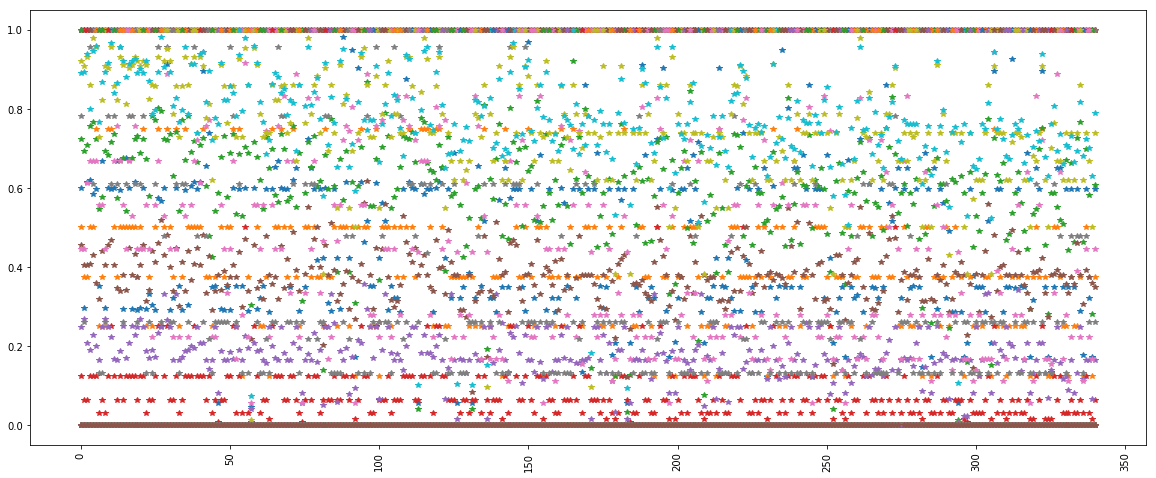

In [363]:
plt.figure(figsize=(20, 8))
plt.plot(X_train,'*')
plt.xticks(rotation = 'vertical')
plt.show()

In [364]:
print(X_train.shape,X_test.shape)


(341, 86) (119, 86)


In [365]:
X_train = X_train.values
X_test = X_test.values

# Perceptron Class

$y = 1,\mbox{if} \sum_i w_ix_i >= b$

$y = 0, \mbox{otherwise} $

In [366]:
class Perceptron:
  def __init__(self):
    self.w = None
    self.b = None
  
  def model(self, x):
    return 1 if (np.dot(self.w, x) >= self.b) else 0
  
  def predict(self, X):
    Y = []
    for x in X:
      result = self.model(x)
      Y.append(result)
    return np.array(Y)

  def fit(self, X, Y, epochs = 2, lr = 1):
    self.w = np.ones(X.shape[1])
    self.b = 0

    accuracy = {}
    max_accuracy = 0

    wt_matrix = []

    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      for x, y in zip(X, Y):
        y_pred = self.model(x)
        if y_pred == 0 and y == 1:
          self.w = self.w + lr * x
          self.b = self.b + lr * 1
        elif y_pred == 1 and y == 0:
          self.w = self.w - lr * x
          self.b = self.b - lr * 1

      wt_matrix.append(self.w)

      accuracy[i] = accuracy_score(self.predict(X), Y)
      if accuracy[i] > max_accuracy:
        max_accuracy = accuracy[i]
        chkpt_w = self.w
        chkpt_b = self.b
    
    self.w = chkpt_w
    self.b = chkpt_b

    print(max_accuracy)
    accuracy_list = list(accuracy.values())
    plt.plot(accuracy_list)
    plt.ylim([0,1])
    plt.show()

    return np.array(wt_matrix)


In [367]:
perceptron = Perceptron()

A Jupyter Widget


0.856304985337


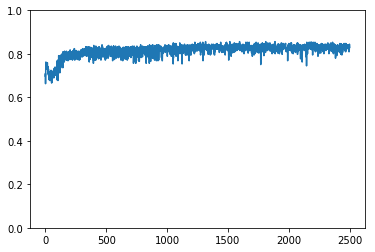

In [368]:
wt_matrix = perceptron.fit(X_train, Y_train, 2500, 0.01)

In [374]:
Y_pred_test = perceptron.predict(X_test)

In [375]:
print(Y_pred_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1]


In [376]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':Y_pred_test})
submission = submission[['PhoneId', 'Class']]
submission.head()

,PhoneId,Class
0,3,1
1,11,1
2,13,1
3,16,1
4,19,1


In [377]:
pwd

'C:\\Users\\suraj\\Desktop\\mtech_sem2\\GUVI DeepLearning\\Mobile_Like_Dislike_MPNeuron'

In [378]:
submission.to_csv("submission_p.csv", index=False)